Update CRATE_HOSTS to connect to a cluster with the `benchmarks` table:

In [1]:
CRATE_HOSTS = 'localhost:4400'

In [23]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import collections
import itertools

from crate.client import connect
conn = connect(CRATE_HOSTS)
cursor = conn.cursor()

Row = collections.namedtuple('Row', ('version', 'mean', 'stdev'))

def get_last_version(stmt, name, version):
    cursor.execute("""
        select
            version_info['number'] || '-' || substr(version_info['hash'], 0, 9) as version
        from
            benchmarks
        where
            version_info['number'] like ?
            and statement = ?
            and meta['name'] = ?
        order by 1 desc
        limit 1
    """, (version, stmt, name))
    row = cursor.fetchone()
    return row[0] if row else None


def get_version_specific_rows(stmt, name, version_incl_hash):
    if not version_incl_hash:
        return []
    cursor.execute("""
        select
            version_info['number'] || '-' || substr(version_info['hash'], 0, 9) as version,
            avg(runtime_stats['mean']) as mean,
            avg(runtime_stats['stdev']) as stdev
        from 
            benchmarks
        where
            version_info['number'] || '-' || substr(version_info['hash'], 0, 9) = ?
            and statement = ?
            and meta['name'] = ?
        group by 1
        order by 1 desc
    """, (version_incl_hash, stmt, name))
    return [Row(*row) for row in cursor.fetchall()]
    

def get_rows(stmt, name):
    rows = get_version_specific_rows(
        stmt, name, get_last_version(stmt, name, '0.56.%'))
    rows += get_version_specific_rows(
        stmt, name, get_last_version(stmt, name, '0.57.%'))
    cursor.execute("""
        select
            version_info['number'] || '-' || substr(version_info['hash'], 0, 9) as version,
            avg(runtime_stats['mean']) as mean,
            avg(runtime_stats['stdev']) as stdev
        from 
            benchmarks
        where 
            statement = ?
            and meta['name'] = ?
        group by 1
        order by 1 desc
        limit 5
    """, (stmt, name))
    rows += [Row(*row) for row in cursor.fetchall()]
    return rows

n_figure = itertools.count(0)

def bar_plot(stmt, filename):
    plt.figure(next(n_figure))
    rows = get_rows(stmt, filename)
    versions = [r.version for r in rows]
    plt.xticks(range(len(versions)), versions, rotation=45)
    x = list(range(len(versions)))
    plt.title(stmt)
    plt.xlabel('version')
    plt.ylabel('ms')
    error_config = {'ecolor': '0.3'}
    plt.bar(
        range(len(rows)),
        [r.mean for r in rows],
        yerr=[r.stdev for r in rows],
        error_kw=error_config,
        color='g',
        label='mean'
    )
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    
def plot_file(filename):
    cursor.execute("""
        select distinct
            statement,
            meta['name']
        from
            benchmarks
        where
            meta['name'] = ?
        order by
            statement
    """, (filename,))

    rows = cursor.fetchall()
    for stmt, name in rows:
        bar_plot(stmt, name)

<IPython.core.display.Javascript object>


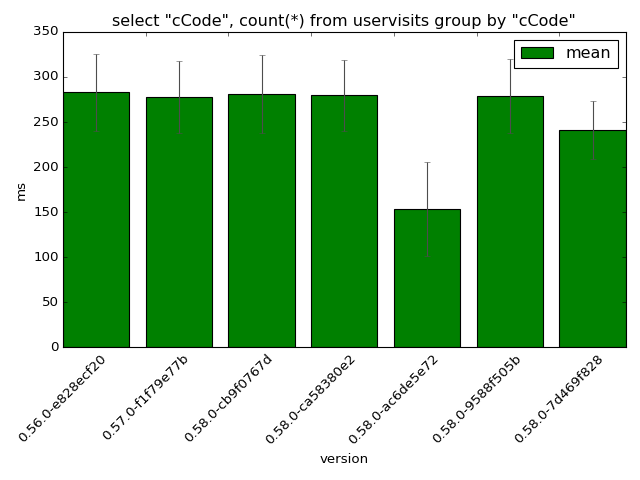

In [28]:
bar_plot('select "cCode", count(*) from uservisits group by "cCode"', 'group_by.toml')

<IPython.core.display.Javascript object>


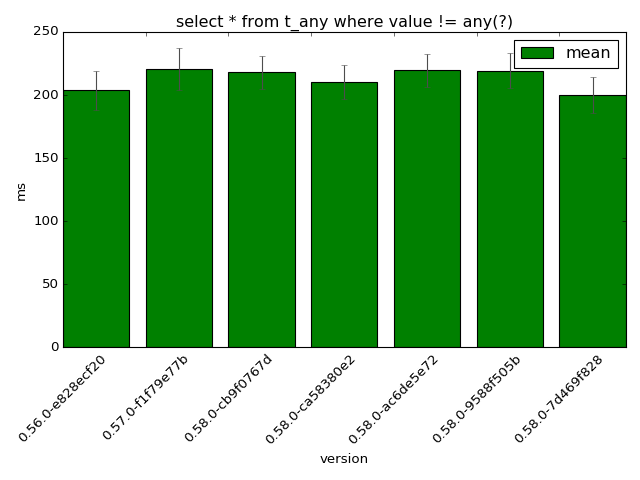

<IPython.core.display.Javascript object>


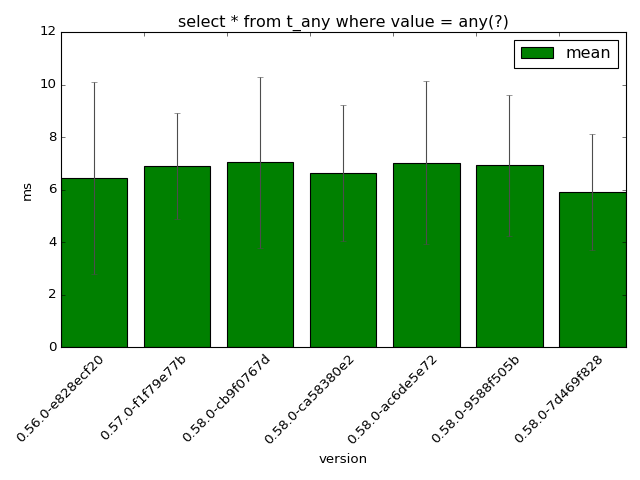

In [27]:
plot_file('any.py')